# Grader Guidelines

*Expected runtime*: 45 minutes

*Requirements*:

* Download `train.csv`, `test.csv`, and the `images.zip` from https://www.kaggle.com/competitions/leaf-classification/data
* Put `train.csv` and `test.csv` (unzip if needed) into a subdirectory of the directory you're running this notebook from: `./CSV`.  Unzip the contents of `images.zip` to `[directory of this .ipynb]/images`.

This notebook __must__ be run first, as the CSVs generated here are used by some deep learning models.  You will also need to run the other notebooks from the same directory, since they will need the output CSVs.

Additionally, some cells in this notebook are resource intensive (16 GB of RAM is sufficient, but I'm not sure exactly how much is needed).  Use the constants in the next cell to control which parts are run.  Be aware that if you set these constants to `False`, *other notebooks will __not__ work.*

In [1]:
# Controls whether preprocessed, transformed data is saved to a CSV--the CSV is used by some our our deep learning models
EXPORT_TO_CSV = True

# Controls whether data augmentation is performed.  This is also saved to a CSV.
# 16 GB of RAM and at least 4 GB of storage space should be sufficient.
USE_DATA_AUGMENTATION = True

In [2]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from scipy.stats import randint
import PIL.Image as Image
import os

import random

import torch
from torchvision.transforms import v2 as transforms
from torchvision.io import read_image, ImageReadMode
from PIL import Image
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Preprocessing

In [3]:
# Image size constants for convenience
IMAGE_X, IMAGE_Y = 200, 200     # Resize all images to these dimensions
IMAGE_DIM = (IMAGE_X, IMAGE_Y)
N_PIXELS = IMAGE_X * IMAGE_Y    # Number of pixels in resized images

N_IMAGES = 1584                 # Original number of instances
AUGMENTED_ORIGINAL_RATIO = 3    # Number of augmented images for every original image

In [4]:
# Read in training and test data
train_df = pd.read_csv("CSV/train.csv", index_col='id')
test_df = pd.read_csv("CSV/test.csv", index_col='id')

#### Initial Image Preprocessing

In [5]:
# Loads an image and applies some basic preprocessing
# to it (resizing, black and white)
def load_image(filename):
    return Image.open(filename) \
                .resize(IMAGE_DIM) \
                .convert(
                    mode='1',   # black and white
                    dither=Image.Dither.NONE,
                )

# Converts a Pillow image to a 1D numpy array of pixel data
def image_to_flat_array(img):
    return np.array(img).reshape((-1))

# Loads images with specified indices into one-dimensional
# pixel data and concatenates it all into a single dataframe
def images_to_df(indices):
    imgs = [
        load_image(f'images/{i}.jpg') for i in indices
    ]

    # Converts each image to flat 1D representation
    df = pd.DataFrame(
               np.asarray(imgs).reshape((len(imgs), -1))
           ).set_index(indices)
    df.columns = df.columns.astype(str)     # Prevents some obscure errors later
    return df

In [6]:
# Load the data corresponding to each dataset
img_train_df = images_to_df(train_df.index).astype(int)
img_test_df = images_to_df(test_df.index).astype(int)

#### Traditional Machine Learning Pipeline

In [7]:
# Add the img_train columns to the preprocessor lists
# Specify the type of each column for us to know what preprocessing needs to be done to each column
numeric_features = [i for i in train_df.drop(columns='species').columns]
passthrough_features = [i for i in img_train_df]

In [8]:
# Define the pipelines for each type of data we have
numeric_pipeline = make_pipeline(
    # Normalize all of them to unit norm
    Normalizer()
)

# Define our column transformer/preprocessor itself
preprocessor = make_column_transformer(
    (numeric_pipeline, numeric_features),
    ('passthrough', passthrough_features)

)

#### Concatenated Dataframes & Column Transformations

In [9]:
# Concatenates the image data with the metadata into one dataframe
full_train_df = pd.concat([train_df, img_train_df], axis=1)
full_test_df = pd.concat([test_df, img_test_df], axis=1)

# We want to split X (big X because it is a matrix) and y from each other
full_X_train = full_train_df.drop(columns=['species'])
full_y_train = full_train_df['species']

# Funnily enough, the test has no ground truth...
full_X_test = full_test_df

# Now we want to fit our preprocessor onto our data, so we can actually transform it (then cast it to a DF)
full_X_train_transformed = pd.DataFrame(preprocessor.fit_transform(full_X_train))
full_X_test_transformed = pd.DataFrame(preprocessor.transform(full_X_test))

### Save the pre-processed data to csv for access in other jupyter notebooks

In [10]:
# This MUST be run (i.e. EXPORT_TO_CSV must be True) for deep learning models
# to work.
if(EXPORT_TO_CSV):
    # By this point, there should already be a ./CSV folder
    if not os.path.exists('CSV/pre-processed'):
        os.mkdir('CSV/pre-processed')

    full_X_train_transformed.to_csv('CSV/pre-processed/full_X_train_transformed')
    full_y_train.to_csv('CSV/pre-processed/full_y_train')


    full_X_test_transformed.to_csv('CSV/pre-processed/full_X_test_transformed')

## Data Augmentation

#### Image Preprocessing Pipelines for Data Augmentation

In [11]:
# Preprocessing pipelines for data augmentation and normalization

# Use a consistent seed
torch.manual_seed(42)   # Use a consistent seed for transformations.
random.seed(42)  # This may be needed as per: https://github.com/pytorch/pytorch/issues/42331

# Used to resize normal images to the same size as augmented images
image_resizer = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(size=(IMAGE_X, IMAGE_Y), antialias=False),
    transforms.ToDtype(torch.float32, scale=True),
])

# Applies data augmentation to images
image_augmentor = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomRotation(degrees=(0, 360), expand=False, fill=(1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # We removed the RandomResizedCrop, since it cropped too much and made scores worse
    #transforms.RandomResizedCrop(size=(IMAGE_X, IMAGE_Y), antialias=False),
    transforms.Resize(size=(IMAGE_X, IMAGE_Y), antialias=False),    # This is still needed so feature size is correct
    transforms.ToDtype(torch.float32, scale=True),
])

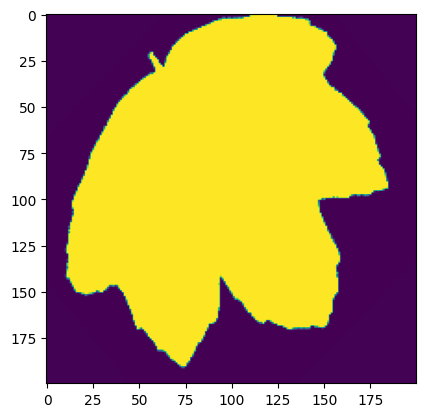

In [12]:
# Verify that image_augmentor applies the desired transformations
img = read_image('images/1.jpg', mode=ImageReadMode.GRAY)
copy = image_resizer(img)
out = [image_augmentor(img) for _ in range(5)]

# Display an augmented image
plt.imshow(out[0][0])

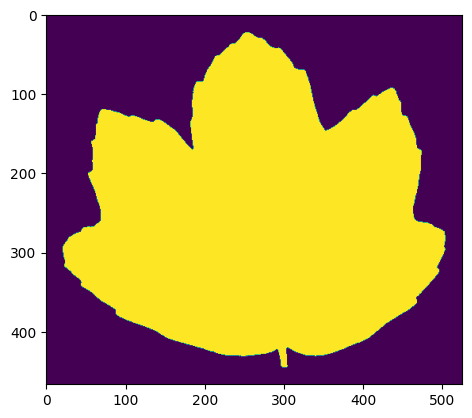

In [13]:
# The original image
plt.imshow(img[0])

In [14]:
# Redefine load_image to use grayscale and pytorch pipeline
# Returns the preprocessed image as a 2D numpy array
def load_image(filename):
    img = read_image(filename, mode=ImageReadMode.GRAY)
    return image_resizer(img)[0].numpy()

# Returns a 2D numpy arrays from the augmented images
def augment_image(filename):
    img = read_image(filename, mode=ImageReadMode.GRAY)
    return image_augmentor(img)[0].numpy()

#### Data Augmentation Function

In [15]:
# Performs image data augmentation on X_train and returns a new dataframe that
# Corresopnds to the updated information
def augmentation(X_train, y_train):
    # These need to be lists to avoid multiple calls to pd.concat()
    # Hold temporary augmented data
    x_aug = []
    y_aug = []
    for idx in X_train.index:
        # Adds AUGMENTED_ORIGINAL_RATIO augmented versions of the image
        for _ in range(AUGMENTED_ORIGINAL_RATIO):
            augmented_img = augment_image(f'images/{idx}.jpg')
            row = X_train.loc[idx].to_list()    # Get metadata
            row[-N_PIXELS:] = augmented_img.reshape(-1)  # Replace image data with augmented data
            x_aug.append(row)
            y_aug.append(y_train.loc[idx])  # Keeps y data consistent

    # Creates an actual dataframe containing all of the data
    # One unfortunate side-effect is that index information is lost for the augmented data
    X_train_augmented = pd.concat([
        X_train,
        pd.DataFrame(
            x_aug,
            # index has to be given arbitrary numbers that don't conflict with anything else
            index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
            columns=X_train.columns
        )
    ])

    y_train_augmented = pd.concat([
        y_train,
        pd.Series(
            y_aug,
            index=pd.RangeIndex(start=N_IMAGES + 1, stop=N_IMAGES + len(x_aug) + 1, name='id'),
            name=y_train.name
        )
    ])
    return X_train_augmented, y_train_augmented


#### Applying Data Augmentation/Saving to CSV

In [16]:
# Full train set data augmentation
#
# Be aware that this will take up to 16GB of RAM depending on AUGMENTED_ORIGINAL_RATIO
# and may take between 10-20 minutes.
if USE_DATA_AUGMENTATION:

    full_X_train_augmented, full_y_train_augmented = augmentation(
        full_X_train, full_y_train
    )

    print(full_X_train_augmented.shape)
    print(full_y_train_augmented.shape)

(3960, 40192)
(3960,)


In [17]:
# Augmented train and corresponding validation/test sets to CSV
if USE_DATA_AUGMENTATION:
    
    # Have to start from the original train data to avoid information leaking
    # from the validation set
    X_train, X_val, y_train, y_val = train_test_split(
        full_X_train, full_y_train
    )

    # Augment and fit/transform the train data
    X_train_augmented, y_train_augmented = augmentation(X_train, y_train)
    X_train_augmented = pd.DataFrame(preprocessor.fit_transform(X_train_augmented), columns=full_X_train.columns)

    # Shuffle train data so that the augmented data for one image are not all right next to each other
    X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

    # Transform the validation set
    X_val = pd.DataFrame(preprocessor.transform(X_val), columns=full_X_train.columns)

    X_test_transformed = pd.DataFrame(preprocessor.transform(full_X_test), columns=full_X_train.columns)

    if EXPORT_TO_CSV:
        if not os.path.exists('CSV/pre-processed/training'):
            os.makedirs('CSV/pre-processed/training')

        X_train_augmented.to_csv('CSV/pre-processed/training/X_train_augmented.csv')
        y_train_augmented.to_csv('CSV/pre-processed/training/y_train_augmented.csv')

        X_val.to_csv('CSV/pre-processed/training/X_validation_augmented.csv')
        y_val.to_csv('CSV/pre-processed/training/y_validation_augmented.csv')

        # X_test properly transformed
        X_test_transformed.to_csv('CSV/pre-processed/training/X_test_augmented.csv')


In [18]:
# Save the full augmented train set to a CSV
if USE_DATA_AUGMENTATION:
    
    # Transform the data
    full_X_train_augmented = pd.DataFrame(preprocessor.fit_transform(full_X_train_augmented), columns=full_X_train.columns)
    
    # Shuffle train data so that the augmented versions of one image are not all right next to each other
    full_X_train_augmented, full_y_train_augmented = shuffle(full_X_train_augmented, full_y_train_augmented)

    full_X_test_final = pd.DataFrame(preprocessor.transform(full_X_test), columns=full_X_train.columns)

    if EXPORT_TO_CSV:
        if not os.path.exists('CSV/pre-processed/training'):
            os.makedirs('CSV/pre-processed/training')

        full_X_train_augmented.to_csv('CSV/pre-processed/training/full_X_train_augmented.csv')
        full_y_train_augmented.to_csv('CSV/pre-processed/training/full_y_train_augmented.csv')
        full_X_test_final.to_csv('CSV/pre-processed/training/full_X_test_augmented.csv')

# Models

In [19]:
# Borrowed from the class notebooks with a few modifications.
# Uses accuracy for the CV metric
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(
        model, X_train, y_train, scoring='accuracy', **kwargs
    )

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index).rename({'test_score': 'validation_score'})

### Manual Dummy Classifier

In [20]:
# Dummy classifer that randomly guesses the species a leaf belongs to
np.random.seed()
dummy = DummyClassifier(
    strategy="uniform",
    random_state=7         # A constant is used to improve reproducibility.
)

In [21]:

mean_std_cross_val_scores(dummy, full_X_train_transformed, full_y_train)

fit_time            0.180 (+/- 0.028)
score_time          0.001 (+/- 0.002)
validation_score    0.014 (+/- 0.012)
dtype: object

With 99 classes, the DummyClassifier's cv-accuracy is a little over 10%, as expected.

### Random Forest

In [22]:
# Testing a random forest
forest = RandomForestClassifier(
    n_jobs=-1,
    warm_start=False,
    random_state = 42,  # For reproducibility
)

# No preprocessing/pipeline is required here, since DecisionTrees don't need scaling
forest_cv_scores = mean_std_cross_val_scores(forest, full_X_train, full_y_train, cv=5)
print(forest_cv_scores)

fit_time            3.363 (+/- 0.343)
score_time          0.380 (+/- 0.047)
validation_score    0.894 (+/- 0.011)
dtype: object


There may be some overfitting here.

We then wanted to evaluate the RandomForest's accuracy on the image data, to see whether it would be better to drop those features altogether.  To that end, we trained two additional RandomForests:

- One on image data only
- One on metadata only

In [23]:
# Evaluate performance on the image data only
forest_img_pipeline = make_pipeline(
    make_column_transformer(
        ('passthrough', passthrough_features),  # Preserve image data features
        remainder='drop',   # Drop metadata features
    ),
    forest,
)

forest_img_cv_scores = mean_std_cross_val_scores(forest_img_pipeline, full_X_train, full_y_train, cv=5)
print(forest_img_cv_scores)

fit_time            3.053 (+/- 0.108)
score_time          0.136 (+/- 0.013)
validation_score    0.557 (+/- 0.015)
dtype: object


In [24]:
# Evaluate performance on the metadata only
forest_metadata_pipeline = make_pipeline(
    make_column_transformer(
        ('passthrough', numeric_features),  # Don't need to normalize numeric data when using a RandomForest
        remainder='drop',   # Drop image features
    ),
    forest,
)

forest_meta_cv_scores = mean_std_cross_val_scores(forest_metadata_pipeline, full_X_train, full_y_train, cv=5)
print(forest_meta_cv_scores)

fit_time            1.920 (+/- 0.204)
score_time          0.055 (+/- 0.009)
validation_score    0.976 (+/- 0.006)
dtype: object


Out of all three RandomForests, the metadata-only RandomForest has the best CV accuracy, although this did not necessarily translate into a good Kaggle score.  It seems that there is still some overfitting, despite the cross-validation score.  Some of the information I've looked into indicates that sklearn's OOB score might be a better metric for evaluating how well the model will generalize if we were to do this project again.

We tried hyperparameter optimization on the metadata-only forest

In [25]:
rscv = RandomizedSearchCV(
    forest_metadata_pipeline,
    {
        # Although more estimators would always seem to be better, even when we
        # did this with between 20, 1000 estimators, the best scoring estimator
        # consistently had between 430-480 estimators, regardless of other parameters.
        'randomforestclassifier__n_estimators': randint(450, 500),
        'randomforestclassifier__max_depth': [10, 30, 80, None],
        # sqrt ~= 14, log2 ~= 8
        'randomforestclassifier__max_features': [5, 'log2', 'sqrt', 21],
    },
    n_jobs=-1,
    n_iter=20,
    random_state=42,
)

# Performs CV implicitly
rscv.fit(full_X_train, full_y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('passthrough',
                                                                               'passthrough',
                                                                               ['margin1',
                                                                                'margin2',
                                                                                'margin3',
                                                                                'margin4',
                                                                                'margin5',
                                                                                'margin6',
                                                                                'margin7',
                                                                                'margin8',
                                                                                'margin9',
                                                                                'margin10',
                                                                                'margin11',
                                                                                'margin12',
                                                                                'margin13',
                                                                                'margin14',
                                                                                'margin15',
                                                                                'margin16',
                                                                                'margin17',
                                                                                'margin18',
                                                                                'margin19',
                                                                                'margin20',
                                                                                'margin21',...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [10,
                                                                              30,
                                                                              80,
                                                                              None],
                                        'randomforestclassifier__max_features': [5,
                                                                                 'log2',
                                                                                 'sqrt',
                                                                                 21],
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000171A564BE10>},
                   random_state=42)

In [26]:
print(rscv.best_params_)
print(rscv.best_score_)

{'randomforestclassifier__max_depth': 80, 'randomforestclassifier__max_features': 21, 'randomforestclassifier__n_estimators': 452}
0.9848484848484848


*Since RandomForest has highest accuracy with metadata only, we may have better luck just throwing out the image data for this classifier type*

### Voting Classifier

Can a RandomForest trained on the image data help improve the score of the metadata-only RandomForest by catching some edge cases?

In [27]:
voting = VotingClassifier(
    estimators=[
        ('meta', rscv.best_estimator_),
        ('img', forest_img_pipeline)
    ],
    voting='soft',
    n_jobs=-1,
)

X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, train_size=0.8)

mean_std_cross_val_scores(voting, full_X_train, full_y_train)

fit_time            16.647 (+/- 1.646)
score_time           0.528 (+/- 0.163)
validation_score     0.986 (+/- 0.004)
dtype: object

There's not much change in performance and it seems like there still might be some overfitting still.

## Test Set Predictions for Kaggle

In [28]:
# Outputs a CSV of predictions for each classifier's submission to Kaggle
def create_report(clf, filename):
    # Predict probabilities for each class
    proba = pd.DataFrame(
        clf.predict_proba(full_X_test),
        columns=dummy.classes_,
        index=test_df.index   
    )

    
    # Output to CSV for submission
    if not os.path.exists('Reports/'):
        os.mkdir('Reports')

    proba.to_csv('Reports/{filename}')

In [29]:
# Dummy Classifier
create_report(
    dummy.fit(full_X_train_transformed, full_y_train), 
    'DummyClassifier.csv'
)

In [30]:
# Hyperparameter-optimized metadata-only RandomForest
create_report(
    rscv.best_estimator_.fit(full_X_train, full_y_train),
    'RandomForestMetadataOnly.csv'
)

In [31]:
# VotingClassifier with two RandomForests
create_report(
    voting.fit(full_X_train, full_y_train),
    'VotingClassifier'
)